In [1]:
%run state_abbrevs.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
tqdm.pandas()

### Plot helper function

In [3]:
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    #print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

### Start NB

In [35]:
agg_2018 = pd.read_csv('/Volumes/MW-4/_HW-Ji/18/18-agg_year.csv')
agg_2019 = pd.read_csv('/Volumes/MW-4/_HW-Ji/19/19-agg_year.csv')
agg_2020 = pd.read_csv('/Volumes/MW-4/_HW-Ji/20/20-agg_year.csv')

In [36]:
agg_2018['week_'] = pd.to_datetime(agg_2018['week'], yearfirst=True)
agg_2019['week_'] = pd.to_datetime(agg_2019['week'], yearfirst=True)
agg_2020['week_'] = pd.to_datetime(agg_2020['week'], yearfirst=True)

In [9]:
areas18 = pd.read_pickle('../../21_6_6_/notebooks/areas18.pkl')
areas19 = pd.read_pickle('../../21_6_6_/notebooks/areas19.pkl')
areas20 = pd.read_pickle('../../21_6_6_/notebooks/areas20.pkl')

In [10]:
areas18['week_'] = pd.to_datetime(areas18['week'], yearfirst=True)
areas19['week_'] = pd.to_datetime(areas19['week'], yearfirst=True)
areas20['week_'] = pd.to_datetime(areas20['week'], yearfirst=True)

### Separate Each Year's Parks By Size -- top 80th percentile

In [11]:
def add_size(area_thresh, df):
    df['size'] = (df['area (km sq)'].
                    apply(lambda x: 'Top 80 Percentile' if x >= area_thresh else 'Bottom 80 Percentile'))
    return df

In [12]:
def groupby_week(df):
    df_weekly = (df.groupby(['week_', 'size'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))
    return df_weekly

In [13]:
top_80_2018 = areas18['area (km sq)'].quantile(.80)
top_80_2019 = areas19['area (km sq)'].quantile(.80)
top_80_2020 = areas20['area (km sq)'].quantile(.80)

In [14]:
areas18 = add_size(top_80_2018, areas18)
areas19 = add_size(top_80_2019, areas19)
areas20 = add_size(top_80_2020, areas20)

In [15]:
areas18_weekly = groupby_week(areas18)
areas19_weekly = groupby_week(areas19)
areas20_weekly = groupby_week(areas20)

In [16]:
to_plot_areas18 = areas18_weekly.copy()
to_plot_areas19 = areas19_weekly.copy()
to_plot_areas20 = areas20_weekly.copy()

In [17]:
to_plot_1819 = to_plot_areas18.append(to_plot_areas19, ignore_index=True)
to_plot1920 = to_plot_areas19.append(to_plot_areas20, ignore_index=True)

In [18]:
to_plot_1819.set_index('week_', inplace=True)
to_plot1920.set_index('week_', inplace=True)

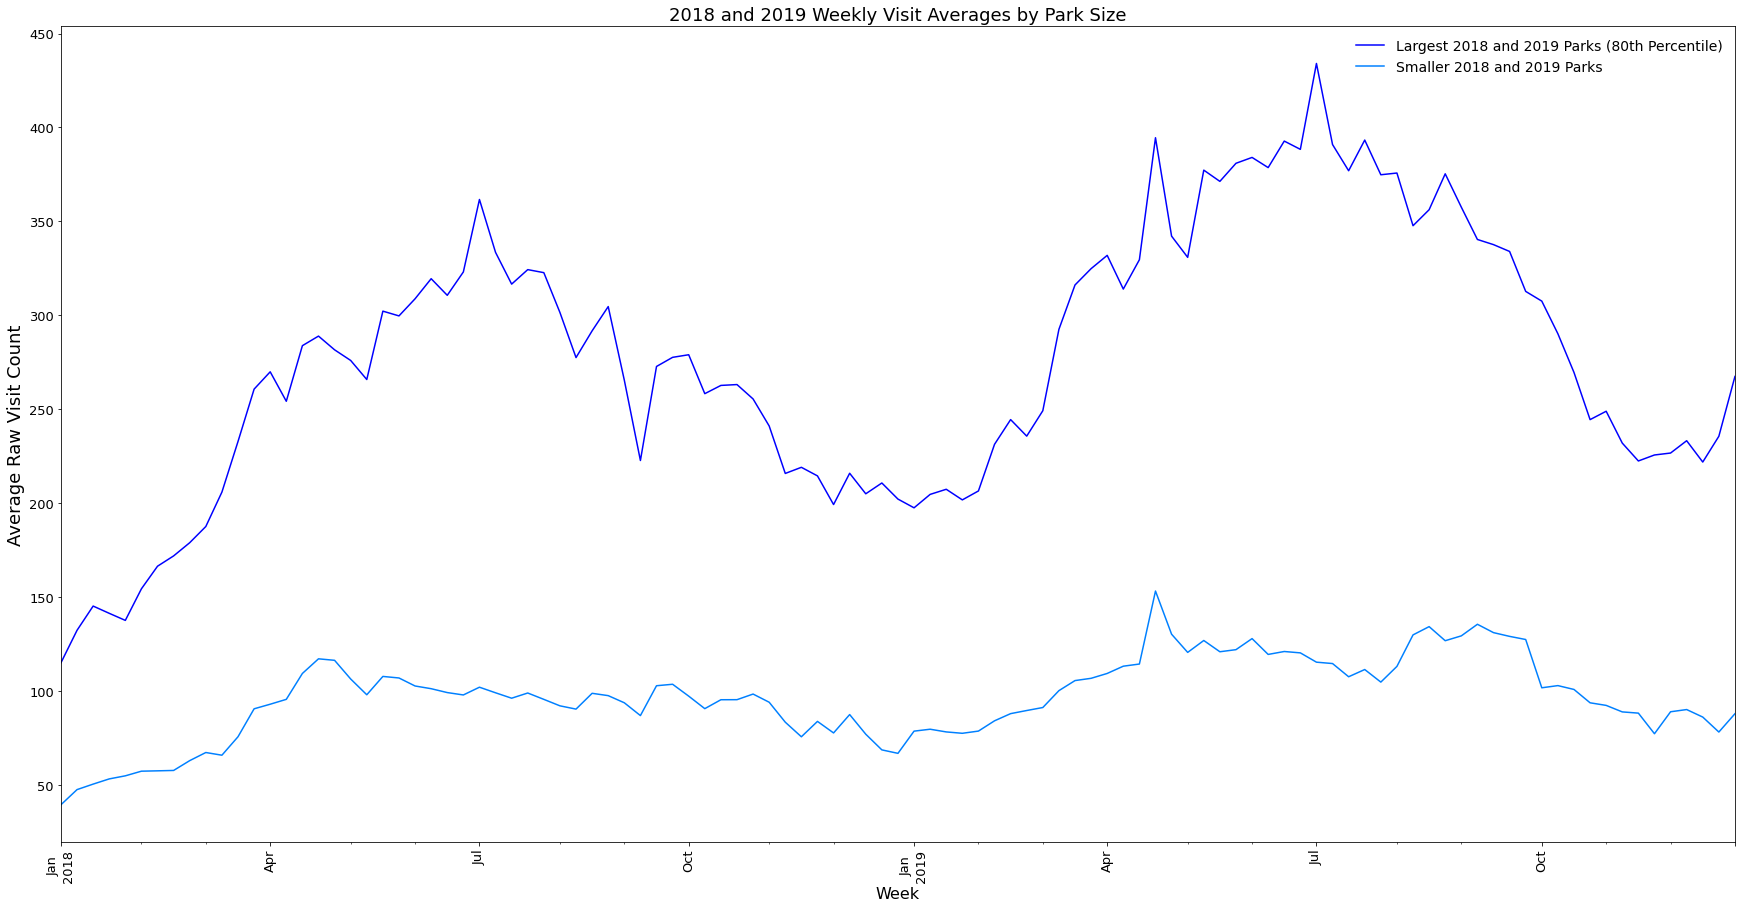

In [19]:
fig, ax = plt.subplots(figsize=(30,15))

ax.set_xticks(range(0,len(to_plot_1819.index)))

label1="Largest 2018 and 2019 Parks (80th Percentile)"
label2="Smaller 2018 and 2019 Parks"

to_plot_1819.query("size=='Top 80 Percentile'").plot(kind="line", color="blue", label=label1, ax=ax)
to_plot_1819.query("size=='Bottom 80 Percentile'").plot(kind="line", color="#0080FF", label=label2, ax=ax)

plt.title("2018 and 2019 Weekly Visit Averages by Park Size", fontsize=18)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.xticks(rotation=90)

plt.legend(loc=1, prop={'size': 18})
ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2], fontsize=14, frameon=False)

In [1]:
### now 2019 and 2020

In [20]:
to_plot_areas20 = areas20_weekly.copy()
to_plot_areas20.set_index('week_', inplace=True)

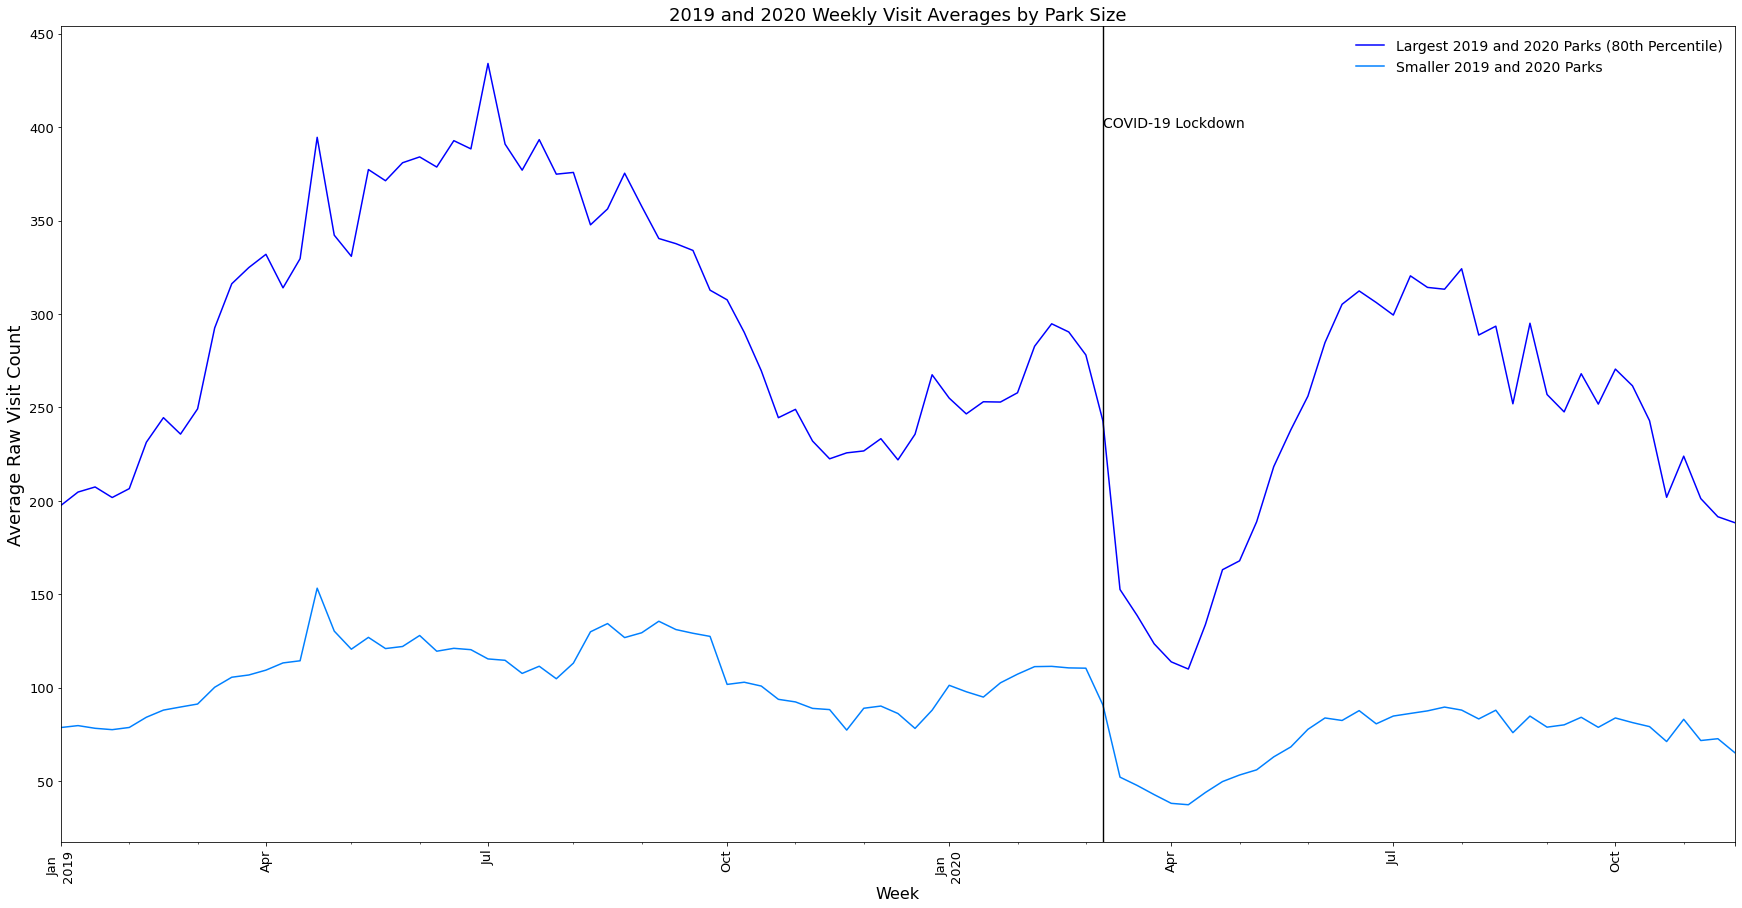

In [21]:
fig, ax = plt.subplots(figsize=(30,15))

ax.set_xticks(range(0,len(to_plot1920.index)))

label1="Largest 2019 and 2020 Parks (80th Percentile)"
label2="Smaller 2019 and 2020 Parks"

to_plot1920.query("size=='Top 80 Percentile'").plot(kind="line", color="blue", label=label1, ax=ax)
to_plot1920.query("size=='Bottom 80 Percentile'").plot(kind="line", color="#0080FF", label=label2, ax=ax)

plt.title("2019 and 2020 Weekly Visit Averages by Park Size", fontsize=18)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.xticks(rotation=90)
plt.text(x="2020-03-09", y=400, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2], fontsize=14, frameon=False)

### Plot largest and smallest national and state parks (80th percentile) for 2020 and 2019

In [22]:
weekly_20_feat = (areas20.groupby(['week_', 'feattype', 'size'], as_index=False)['raw_visit_counts'].mean()
                 .rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

In [23]:
filt_weekly_20_feat = (weekly_20_feat[(weekly_20_feat['feattype']=='State park') 
                                      | (weekly_20_feat['feattype']=='National park')])

In [24]:
to_plot_weekly20_feat = filt_weekly_20_feat.copy()
to_plot_weekly20_feat.set_index('week_', inplace=True)

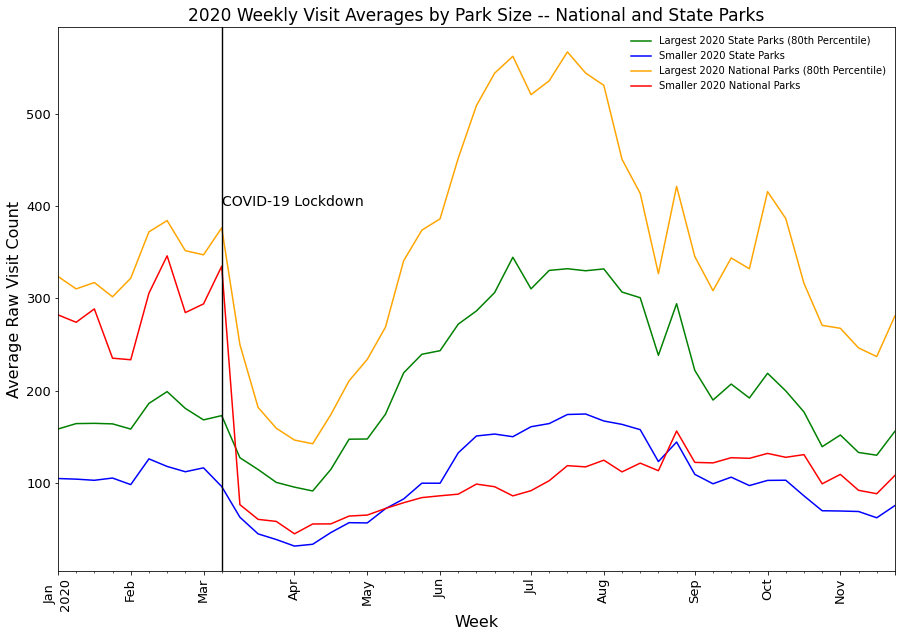

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks(range(0,len(to_plot_weekly20_feat.index)))

label1="Largest 2020 State Parks (80th Percentile)"
label2="Smaller 2020 State Parks"
label3= "Largest 2020 National Parks (80th Percentile)"
label4= "Smaller 2020 National Parks"


to_plot_weekly20_feat.query("size=='Top 80 Percentile' and feattype=='State park'").plot(kind="line", color="green", label=label1, ax=ax)
to_plot_weekly20_feat.query("size=='Bottom 80 Percentile' and feattype=='State park'").plot(kind="line", color="blue", label=label2, ax=ax)
to_plot_weekly20_feat.query("size=='Top 80 Percentile' and feattype=='National park'").plot(kind="line", color="orange", label=label3, ax=ax)
to_plot_weekly20_feat.query("size=='Bottom 80 Percentile' and feattype=='National park'").plot(kind="line", color="red", label=label4, ax=ax)


plt.title("2020 Weekly Visit Averages by Park Size -- National and State Parks", fontsize=17)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.xticks(rotation=90)

plt.text(x="2020-03-09", y=400, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2, label3, label4],frameon=False)

### 2019

In [26]:
weekly_19_feat = (areas19.groupby(['week_', 'feattype', 'size'], as_index=False)['raw_visit_counts'].mean()
                 .rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))
filt_weekly_19_feat = (weekly_19_feat[(weekly_19_feat['feattype']=='State park') 
                                      | (weekly_19_feat['feattype']=='National park')])

In [27]:
to_plot_weekly19_feat = filt_weekly_19_feat.copy()
to_plot_weekly19_feat.set_index('week_', inplace=True)

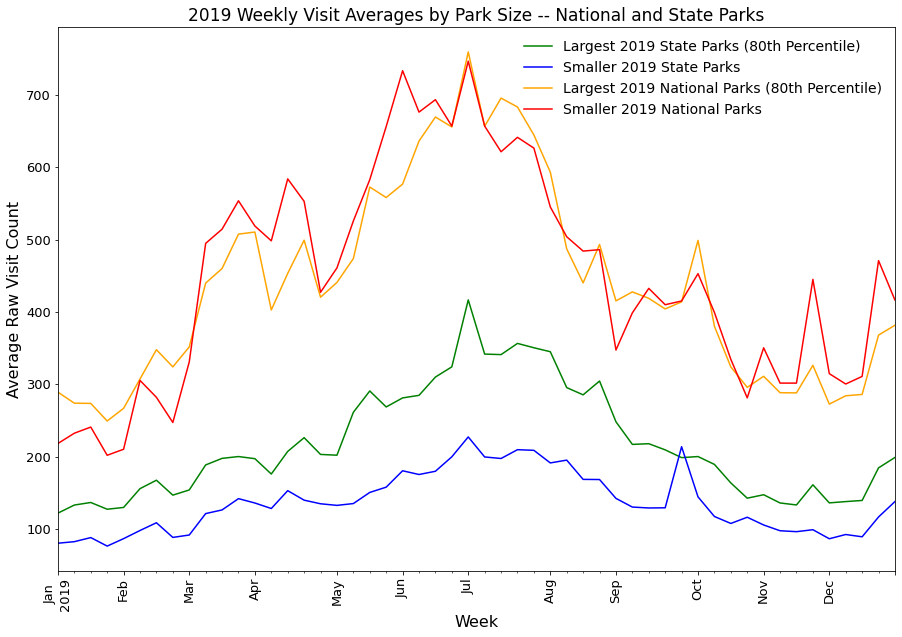

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks(range(0,len(to_plot_weekly19_feat.index)))

label1="Largest 2019 State Parks (80th Percentile)"
label2="Smaller 2019 State Parks"
label3= "Largest 2019 National Parks (80th Percentile)"
label4= "Smaller 2019 National Parks"


to_plot_weekly19_feat.query("size=='Top 80 Percentile' and feattype=='State park'").plot(kind="line", color="green", label=label1, ax=ax)
to_plot_weekly19_feat.query("size=='Bottom 80 Percentile' and feattype=='State park'").plot(kind="line", color="blue", label=label2, ax=ax)
to_plot_weekly19_feat.query("size=='Top 80 Percentile' and feattype=='National park'").plot(kind="line", color="orange", label=label3, ax=ax)
to_plot_weekly19_feat.query("size=='Bottom 80 Percentile' and feattype=='National park'").plot(kind="line", color="red", label=label4, ax=ax)


plt.title("2019 Weekly Visit Averages by Park Size -- National and State Parks", fontsize=17)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.xticks(rotation=90)

plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2, label3, label4], fontsize=14, frameon=False)

### Long graph showing 2019 and 2020 small and large national and state parks

In [29]:
to_plot1920_feat = filt_weekly_19_feat.append(filt_weekly_20_feat, ignore_index=True)
to_plot1920_feat.set_index('week_', inplace=True)

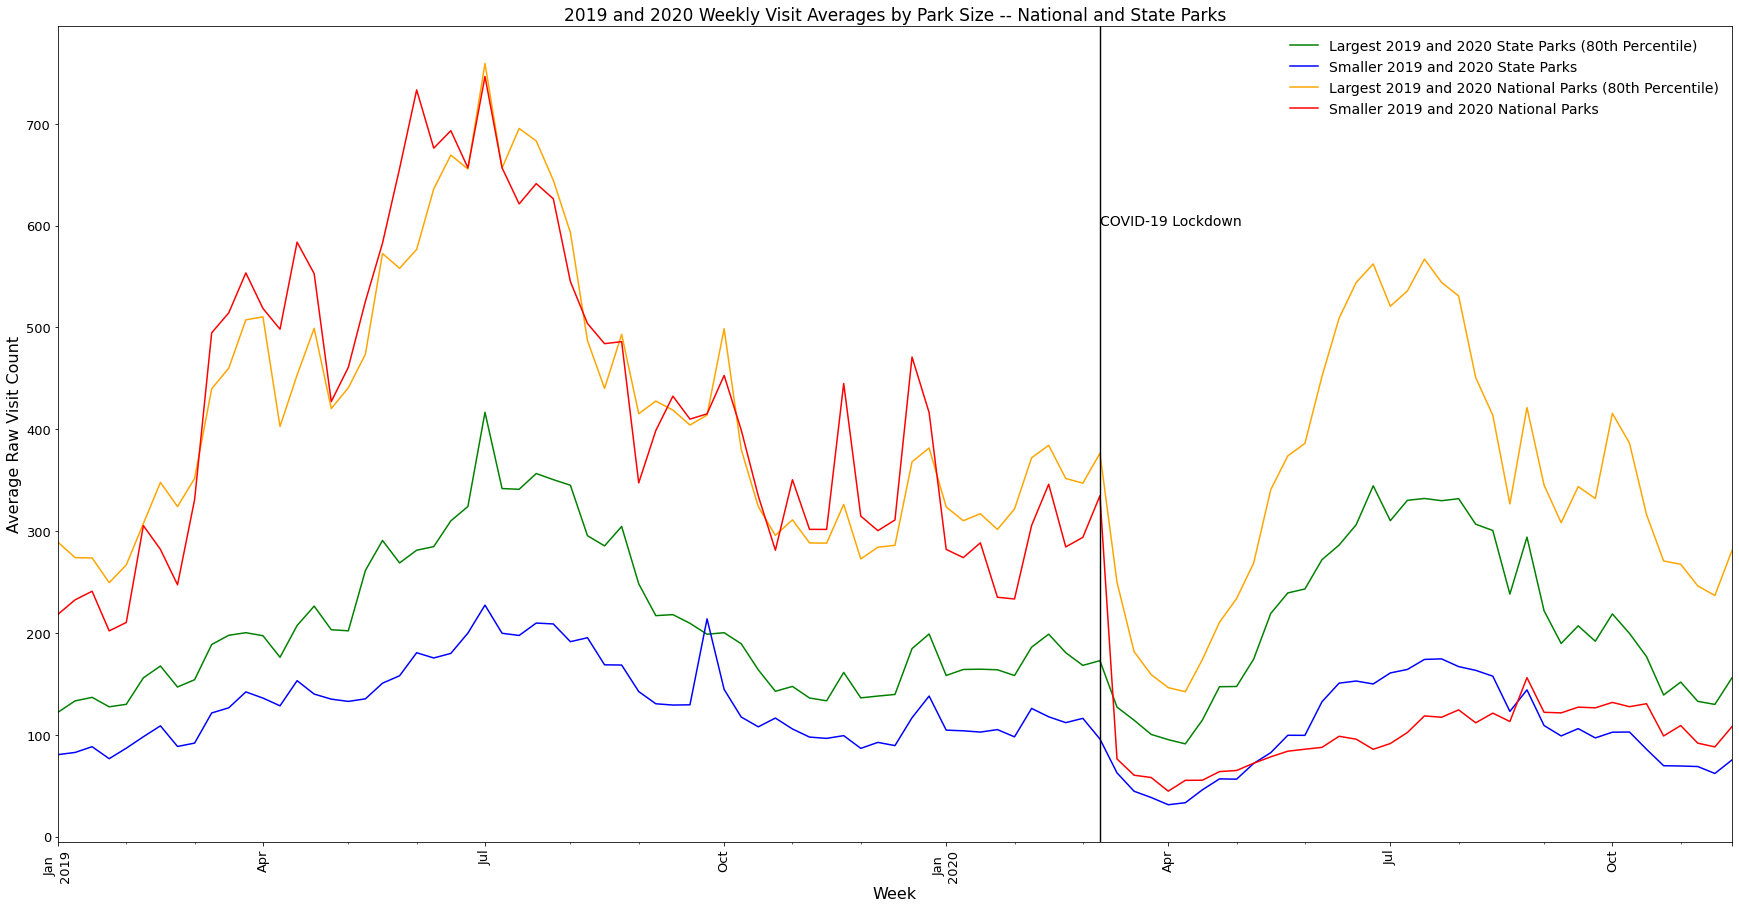

In [30]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_xticks(range(0,len(to_plot1920_feat.index)))

label1="Largest 2019 and 2020 State Parks (80th Percentile)"
label2="Smaller 2019 and 2020 State Parks"
label3= "Largest 2019 and 2020 National Parks (80th Percentile)"
label4= "Smaller 2019 and 2020 National Parks"


to_plot1920_feat.query("size=='Top 80 Percentile' and feattype=='State park'").plot(kind="line", color="green", label=label1, ax=ax)
to_plot1920_feat.query("size=='Bottom 80 Percentile' and feattype=='State park'").plot(kind="line", color="blue", label=label2, ax=ax)
to_plot1920_feat.query("size=='Top 80 Percentile' and feattype=='National park'").plot(kind="line", color="orange", label=label3, ax=ax)
to_plot1920_feat.query("size=='Bottom 80 Percentile' and feattype=='National park'").plot(kind="line", color="red", label=label4, ax=ax)


plt.title("2019 and 2020 Weekly Visit Averages by Park Size -- National and State Parks", fontsize=17)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.xticks(rotation=90)

plt.text(x="2020-03-09", y=600, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2, label3, label4], fontsize=14, frameon=False)

### Split park areas into thirds, and then plot largest third, second largest, and smallest third -- 2019 and 2020

In [268]:
nat_parks_19 = areas19[areas19['feattype']=='National park'].copy()

In [270]:
area_thresh_19 = nat_parks_19['area (km sq)'].quantile(0.6666666)
nat_parks_19['size_thirds'] = (nat_parks_19['area (km sq)'].
                    progress_apply(lambda x: 'Largest Third' if x >= area_thresh_19 else "Not"))

100%|██████████| 16310/16310 [00:00<00:00, 565196.29it/s]


In [271]:
smaller_nat_19 = nat_parks_19[nat_parks_19['size_thirds']=='Not'].copy()
area_thresh_19 = smaller_nat_19['area (km sq)'].quantile(0.6666666)
smaller_nat_19['size_thirds'] = (smaller_nat_19['area (km sq)'].
                apply(lambda x: 'Second Largest Third' if x >= area_thresh_19 else "Smallest Third"))

In [272]:
nat_19_weekly_1 = (nat_parks_19.groupby(['week_', 'size_thirds'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

In [273]:
nat_19_weekly_1 = nat_19_weekly_1[nat_19_weekly_1['size_thirds'] != "Not"].reset_index(drop=True)

In [274]:
nat_19_weekly_2 = (smaller_nat_19.groupby(['week_', 'size_thirds'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

In [275]:
to_plot_nat_19 = nat_19_weekly_1.append(nat_19_weekly_2)
to_plot_nat_19.set_index('week_', inplace=True)

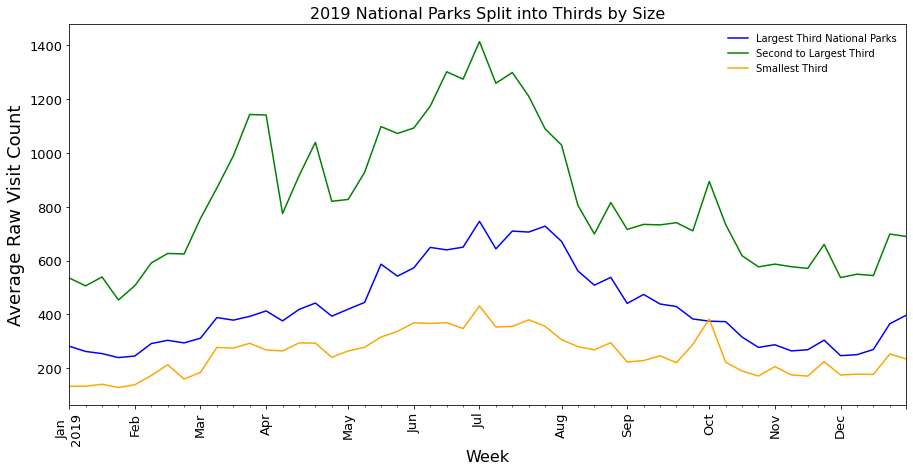

In [291]:
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xticks(range(0,len(nat_19_weekly_1.index)))

label1="Largest Third National Parks"
label2="Second to Largest Third"
label3 = "Smallest Third"

to_plot_nat_19.query("size_thirds=='Largest Third'").plot(kind="line", color="blue", label=label1, ax=ax)
to_plot_nat_19.query("size_thirds=='Second Largest Third'").plot(kind="line", color="green", label=label2, ax=ax)
to_plot_nat_19.query("size_thirds=='Smallest Third'").plot(kind="line", color="orange", label=label3, ax=ax)

plt.title("2019 National Parks Split into Thirds by Size", fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.xticks(rotation=90)

ax.tick_params(labelsize=13)

plt.legend([label1, label2, label3], frameon=False)

### 2020

In [277]:
nat_parks_20 = areas20[areas20['feattype']=='National park'].copy()

In [278]:
area_thresh_20 = nat_parks_20['area (km sq)'].quantile(0.6666666)
nat_parks_20['size_thirds'] = (nat_parks_20['area (km sq)'].
                    progress_apply(lambda x: 'Largest Third' if x >= area_thresh_20 else "Not"))

100%|██████████| 14442/14442 [00:00<00:00, 332222.55it/s]


In [279]:
smaller_nat_20 = nat_parks_20[nat_parks_20['size_thirds']=='Not'].copy()
area_thresh_20 = smaller_nat_20['area (km sq)'].quantile(0.6666666)
smaller_nat_20['size_thirds'] = (smaller_nat_20['area (km sq)'].
                apply(lambda x: 'Second Largest Third' if x >= area_thresh_20 else "Smallest Third"))

In [280]:
nat_20_weekly_1 = (nat_parks_20.groupby(['week_', 'size_thirds'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

In [281]:
nat_20_weekly_1 = nat_20_weekly_1[nat_20_weekly_1['size_thirds'] != "Not"].reset_index(drop=True)

In [282]:
nat_20_weekly_2 = (smaller_nat_20.groupby(['week_', 'size_thirds'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

In [283]:
to_plot_nat_20 = nat_20_weekly_1.append(nat_20_weekly_2)
to_plot_nat_20.set_index('week_', inplace=True)

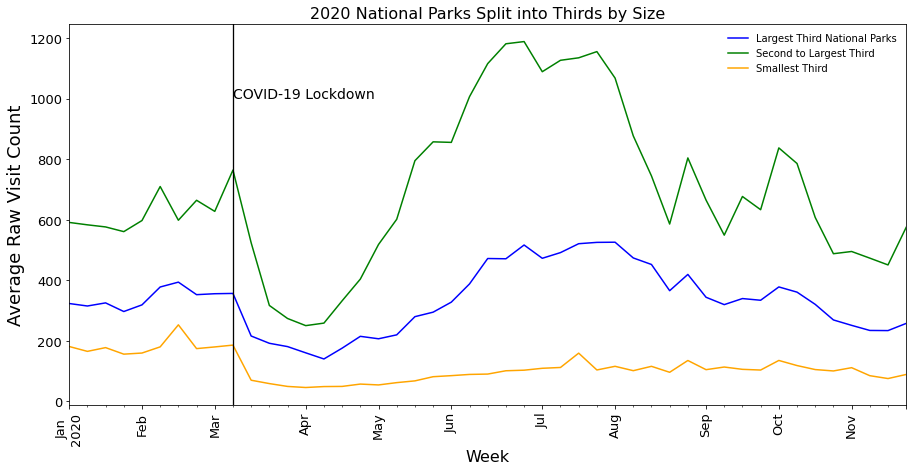

In [290]:
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xticks(range(0,len(nat_20_weekly_1.index)))

label1="Largest Third National Parks"
label2="Second to Largest Third"
label3 = "Smallest Third"

to_plot_nat_20.query("size_thirds=='Largest Third'").plot(kind="line", color="blue", label=label1, ax=ax)
to_plot_nat_20.query("size_thirds=='Second Largest Third'").plot(kind="line", color="green", label=label2, ax=ax)
to_plot_nat_20.query("size_thirds=='Smallest Third'").plot(kind="line", color="orange", label=label3, ax=ax)

plt.title("2020 National Parks Split into Thirds by Size", fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.xticks(rotation=90)

plt.text(x="2020-03-09", y=1000, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.3, color='black')

ax.tick_params(labelsize=13)

plt.legend([label1, label2, label3], frameon=False)

### Park areas split into thirds again -- long graph showing 2019 and 2020

In [285]:
to_plot_nat_1920 = to_plot_nat_19.append(to_plot_nat_20)

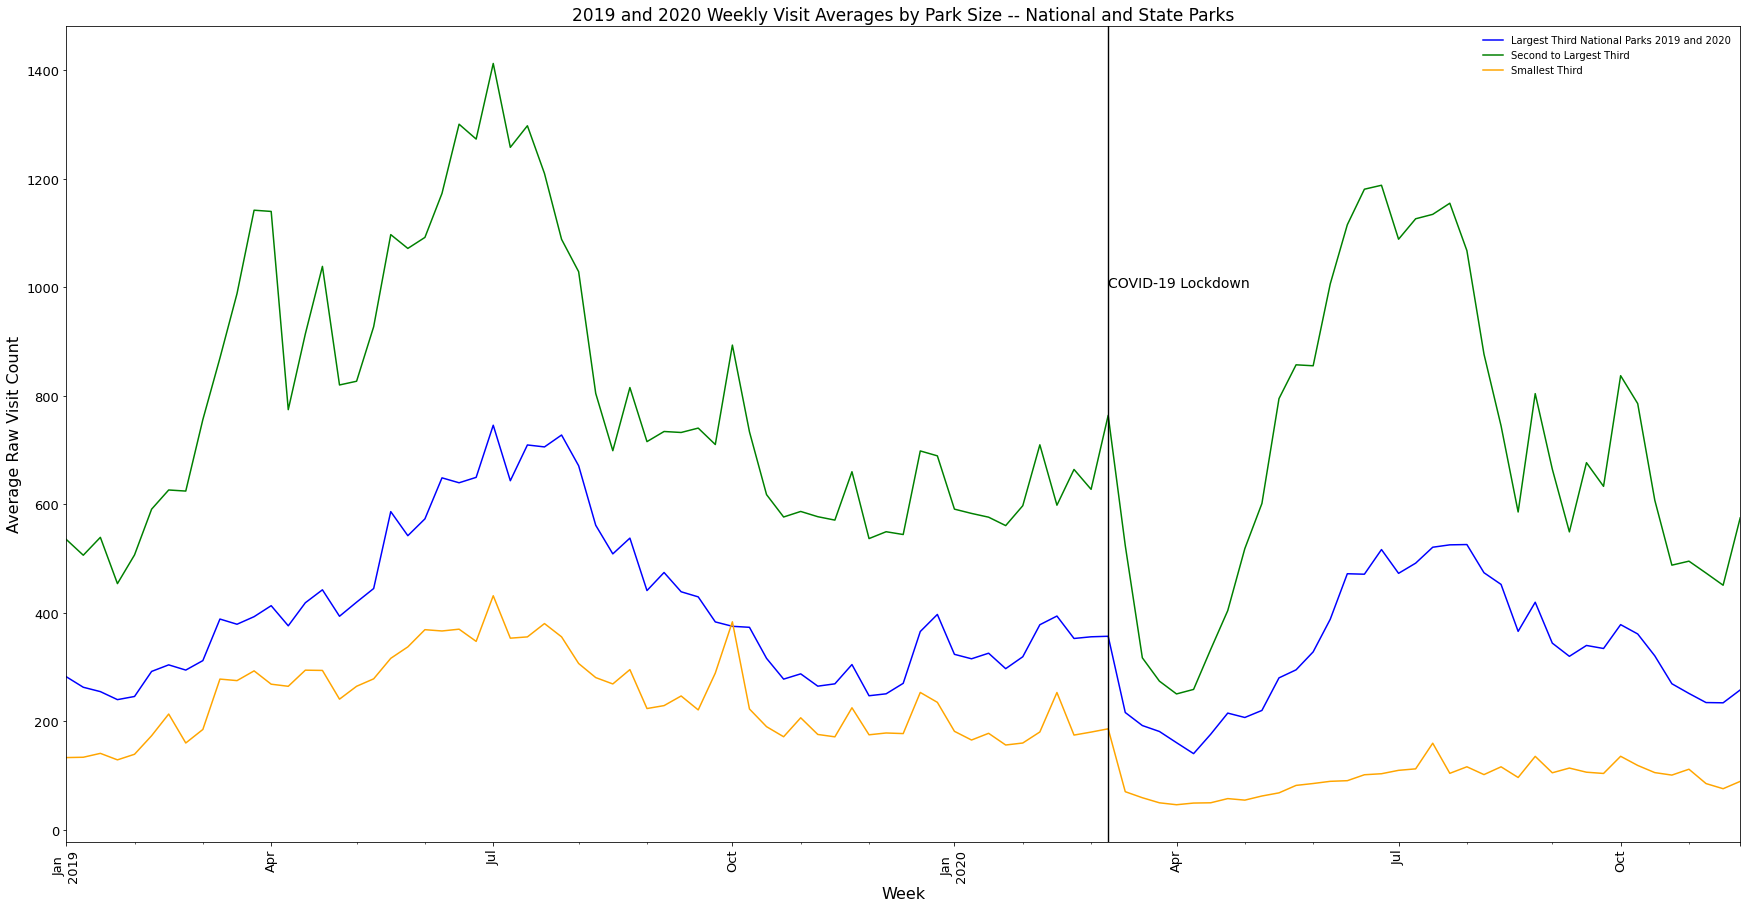

In [289]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_xticks(range(0,len(to_plot_nat_1920.index)))

label1="Largest Third National Parks 2019 and 2020"
label2="Second to Largest Third"
label3= "Smallest Third"


to_plot_nat_1920.query("size_thirds=='Largest Third'").plot(kind="line", color="blue", label=label1, ax=ax)
to_plot_nat_1920.query("size_thirds=='Second Largest Third'").plot(kind="line", color="green", label=label2, ax=ax)
to_plot_nat_1920.query("size_thirds=='Smallest Third'").plot(kind="line", color="orange", label=label3, ax=ax)


plt.title("2019 and 2020 Weekly Visit Averages by Park Size -- National and State Parks", fontsize=17)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.xticks(rotation=90)

plt.text(x="2020-03-09", y=1000, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=13)

plt.legend([label1, label2, label3], frameon=False)

### Plot historial / memorial sites

In [292]:
his_mem_df = nat_parks_20[(nat_parks_20['park_name'].str.contains('Historical')) 
                       |(nat_parks_20['park_name'].str.contains('Memorial'))].copy()

In [293]:
his_mem_df_plot = (his_mem_df.groupby(['week_'], as_index=False)['raw_visit_counts'].mean().
            rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))
his_mem_df_plot.set_index('week_', inplace=True)

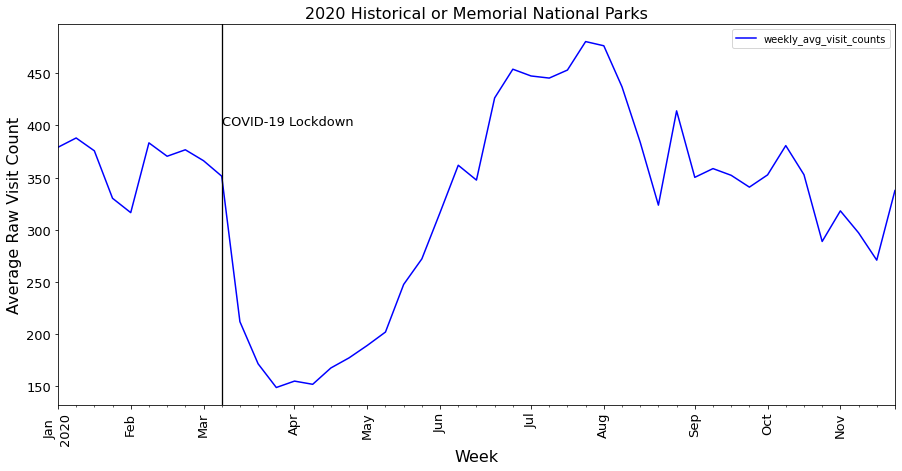

In [295]:
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xticks(range(0,len(his_mem_df_plot.index)))

his_mem_df_plot.plot(kind="line", color="blue", label=label1, ax=ax)

plt.title("2020 Historical or Memorial National Parks", fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.xticks(rotation=90)

plt.text(x="2020-03-09", y=400, s="COVID-19 Lockdown", fontsize=13)
plt.axvline(x="2020-03-09", linewidth=1.3, color='black')

ax.tick_params(labelsize=13)

### Look at how Election Reuslts / Red or Blue States Affects Park Visitation (without distinguishing between park type) for 2020 

**i. ALL DATA (state, local, national, aggregated across all states)**

In [156]:
party_called_df = pd.read_excel('../input_data/Popular vote backend - Sheet1 (cleaned).xlsx')

In [157]:
merged_df = agg_2020.merge(party_called_df, left_on="region", right_on="stateid", how="inner")

In [158]:
plot_weekly_state = (merged_df.groupby(['week_', 'called'], as_index=False)['raw_visit_counts'].mean().
                        rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

plot_weekly_state.set_index('week_', inplace=True)

In [159]:
dem_df = plot_weekly_state[(plot_weekly_state["called"]=="D")]

max_dem_df = dem_df[(dem_df["weekly_avg_visit_counts"]==dem_df["weekly_avg_visit_counts"].max())]
min_dem_df = dem_df[(dem_df["weekly_avg_visit_counts"]==dem_df["weekly_avg_visit_counts"].min())]

rep_df = plot_weekly_state[(plot_weekly_state["called"]=="R")]

max_rep_df = rep_df[(rep_df["weekly_avg_visit_counts"]==rep_df["weekly_avg_visit_counts"].max())]
min_rep_df = rep_df[(rep_df["weekly_avg_visit_counts"]==rep_df["weekly_avg_visit_counts"].min())]

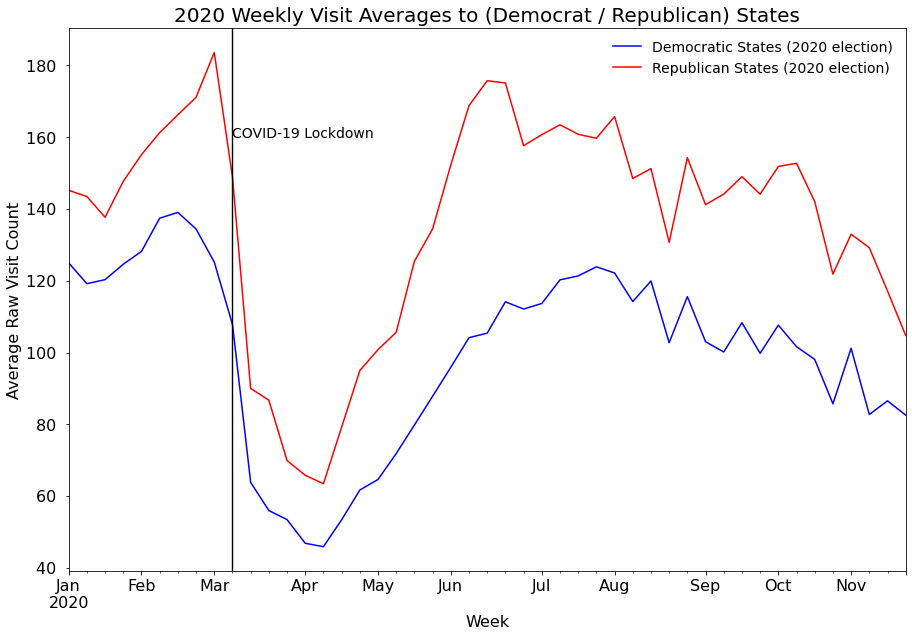

In [168]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks(range(0,len(plot_weekly_state.index)))

label1="Democratic States (2020 election)"
label2="Republican States (2020 election)"

plot_weekly_state.query("called=='D'").plot(kind="line", color="blue", label=label1, ax=ax)
plot_weekly_state.query("called=='R'").plot(kind="line", color="red", label=label2, ax=ax)

plt.title("2020 Weekly Visit Averages to (Democrat / Republican) States", fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Average Raw Visit Count', fontsize=16)
plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

plt.text(x="2020-03-09", y=160, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

plt.legend([label1, label2], fontsize=14, frameon=False)

**ii. National data only, aggregated across all states**

In [315]:
filt_merged_df = merged_df.query("feattype=='National park'").copy()

In [316]:
filt_merged_df = (filt_merged_df.groupby(['week_', 'called'], as_index=False)['raw_visit_counts'].mean().
                        rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

filt_merged_df.set_index('week_', inplace=True)

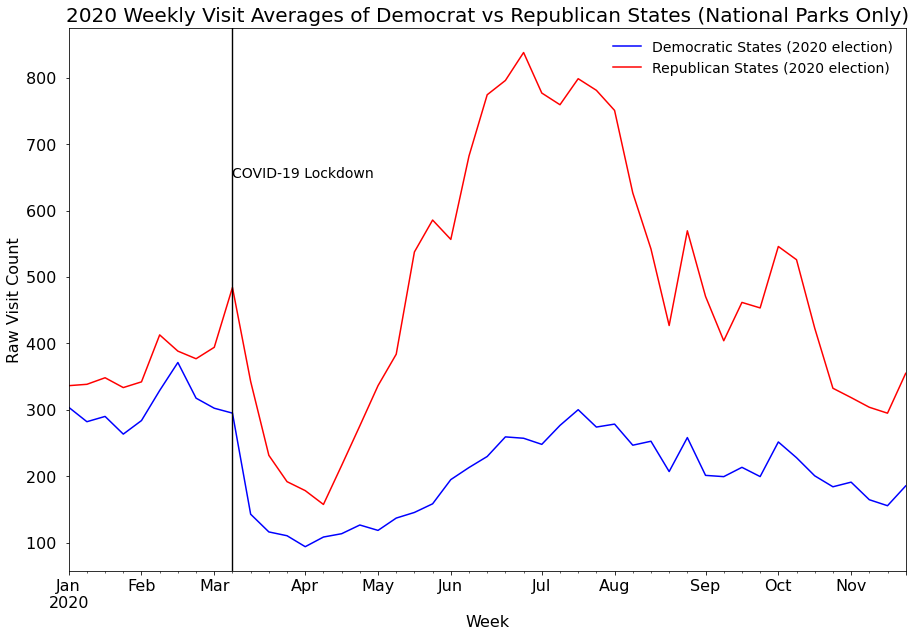

In [318]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks(range(0,len(filt_merged_df.index)))

label1="Democratic States (2020 election)"
label2="Republican States (2020 election)"

filt_merged_df.query("called=='D'").plot(kind="line", color="blue", label=label1, ax=ax)
filt_merged_df.query("called=='R'").plot(kind="line", color="red", label=label2, ax=ax)

plt.title("2020 Weekly Visit Averages of Democrat vs Republican States (National Parks Only)", fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Raw Visit Count', fontsize=16)
plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

plt.text(x="2020-03-09", y=650, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.4, color='black')

plt.legend([label1, label2], fontsize=14, frameon=False)

**iii. Grouped by all park types, D/R**

In [218]:
feattype_merged_df = (merged_df.groupby(['week_', 'feattype', 'called'], as_index=False)['raw_visit_counts'].mean().
                        rename(columns= {'raw_visit_counts': 'weekly_avg_visit_counts'}))

feattype_merged_df.set_index('week_', inplace=True)

In [219]:
plot_colors = [
    '#000066',
    '#0000CC',
    '#3399FF',
    '#66B2FF',
    '#99CCFF',
    
    '#660000',
    '#CC0000',
    '#FF3333',
    '#FF6666',
    '#FF9999'
    
]

In [220]:
plot_dfs = []
for called in feattype_merged_df["called"].unique():
    
    for feattype in feattype_merged_df["feattype"].unique():
        plot_df = feattype_merged_df.query("called==@called and feattype==@feattype").copy()
        plot_dfs.append(plot_df)

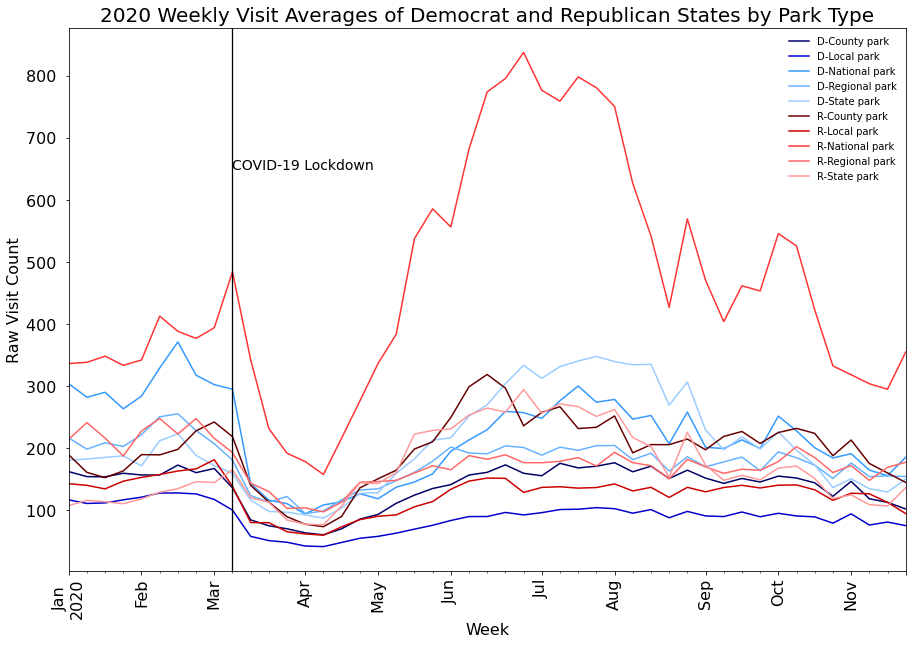

In [334]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticks(range(0,len(feattype_merged_df.index)))

for df, color in zip(plot_dfs, plot_colors):
    called = df["called"].iloc[0]
    feattype = df["feattype"].iloc[0]
    df['weekly_avg_visit_counts'].plot(ax=ax, ylabel="raw visit counts", 
                                       label=f"{called}-{feattype}", 
                                       color=color, 
                                       rot=90)
    

plt.title("2020 Weekly Visit Averages of Democrat and Republican States by Park Type", fontsize=20)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Raw Visit Count', fontsize=16)
plt.legend(loc=1, prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))

plt.text(x="2020-03-09", y=650, s="COVID-19 Lockdown", fontsize=14)
plt.axvline(x="2020-03-09", linewidth=1.3, color='black')

    
plt.legend(frameon=False)